# ForcePlates III: Probabilistic Calibration of Magnitude

Falk Mielke, FunMorph, Universiteit Antwerpen


You can download this notebook [here](user://notebooks/ForcePlates3_Calibration1.ipynb?download&target=_blank).

This is one part of a series of blog posts on Force Plates.
- [ForcePlates I: Notes on Equipment](../fpequipment)
- [ForcePlates II: Calculations](../fpcalculations)
- [ForcePlates III: Probabilistic Calibration of Magnitude](../fpcalibration1)
- [ForcePlates IV: Calibration of Sensor Depth](../fpcalibration2)

Here is a collection of `python` libraries used below, as well as some helper functions.


In [1]:
#######################################################################
### Libraries                                                       ###
#######################################################################
# data management
import numpy as NP
import pandas as PD
import scipy.stats as STATS

PD.set_option('precision', 5) # for display

# probablilistic programming, used here for regression
import pymc3 as PM


# plots and graphics
import matplotlib as MP
import matplotlib.pyplot as MPP
from IPython.core.display import SVG

%matplotlib inline


After the previous texts on good or bad business attitude of companies, and on the physical models of force plates, let's move on towards accurately measuring meaningful values.


To get something out of the voltage signals that the DAQ provides, we need to calculate forces and moments accurately and in the correct units from the output on the amplifiers. 

This requires two tyes of calibrations: 
- calibrating the voltage-force conversion factor ("magnitude" or "scale", this post)
- calculating the inherent plate padding and centre of pressure ([next post](../fpcalibration2))

Let's assume we have force and moment measurements - either because the Kistler software exported them, or because you calculated them _ex post_.
For AMTI, the calibration procedure below will be analogous, but different in some signs (flipped coordinate system).

## Generating Measurements

Before we come to the calibration, some tricks on how to get the data most efficiently.
- record short intervals (e.g. 6 seconds), so you can do many measurement ponits
- pre- or post trigger, as pleases
- take loading off after half of the time
- take the recording software you like, but make sure you can get forces and moments out.

I will explain more of this below. But let's first look at an [example recording](user://notebooks/example_recording.csv?target=_blank&download).


In [2]:
# read the data with the pandas library
data = PD.read_csv("example_recording.csv", sep = ';')
data.head()

time     Fx12     Fx34     Fy14     Fy23      Fz1      Fz2      Fz3  \
0  1.55967e+09  0.38455  0.11237 -0.01762  0.09987  0.99141  0.76610  2.04981   
1  1.55967e+09  0.39424  0.11081 -0.01825  0.10112  0.99391  0.77516  2.05325   
2  1.55967e+09  0.38580  0.10300 -0.01606  0.09925  0.99703  0.76985  2.05137   
3  1.55967e+09  0.38549  0.10612 -0.01700  0.10518  0.99516  0.77204  2.05450   
4  1.55967e+09  0.38830  0.10831 -0.01887  0.10487  0.99109  0.76922  2.05106   

       Fz4  
0  0.29487  
1  0.30174  
2  0.29893  
3  0.29986  
4  0.30111

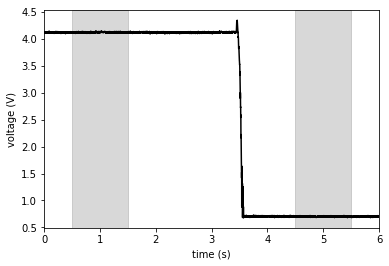

In [3]:

# calculate the total F_z
data['F_z'] = NP.sum(data.loc[:, ['Fz1', 'Fz2', 'Fz3', 'Fz4']].values, axis = 1)

# shift time to be relative
data['time'] -= NP.min(data['time'].values)

# plot F_z
MPP.plot(data['time'].values, data['F_z'].values, 'k-')
MPP.gca().set_xlabel('time (s)')
MPP.gca().set_ylabel('voltage (V)')
MPP.axvspan(0.5, 1.5, color = (0.5,0.5,0.5), alpha = 0.3, zorder = 0)
MPP.axvspan(4.5, 5.5, color = (0.5,0.5,0.5), alpha = 0.3, zorder = 0)
MPP.gca().set_xlim([0.,6.])
MPP.show();

This example shows the voltage trace of an object of a certain weight that was removed from the force plate after about $3.5 s$ through the recording. 
The voltage drop corresponds to the gravitational force which the object excerted on the force plate, before it was taken off.

Because the unloading is done manually, unloading times will be distributed randomly around $t=3 s$ (normally, at best). To make sure that movement artefacts do not interfere, I tend to take the shaded time intervals for calculation of the voltage difference (and double check by plotting all my traces).


This procedure is general and turned out to be useful for quick and accurate calibration.

## Calibration of Voltage-Force Conversion Factor


This is a very straight forward calibration: our $z$-direction sensors output _Volts_, but we want _Newtons_.

We need for this calibration:
- Some random objects of a range of weights
- and a weight scale to get their mass (kitchen- or lab accuracy)
- or calibration weights that have predefined mass
- the gravitational acceleration constant $g$, specific for the planet you live on

Minor complication: Amps have a "gain" (reciprocal: "sensitivity") that can be set. 
In the case of Kistler amps, there are four settings of sensitivity, ranging from $100 pC$ to $5000 pC$. 
The $C$ (Coulomb, as in Piccocoulomb) indicates that this has to do with charge, and the lower $pC$, the higher the output voltage for a given force. 
Hence, Kistler sets a sensitivity (whereas AMTI has a gain, so take the reciprocal in the following formulas).





Now, let's use gravity, which mother earth generously provides for us. Gravitational force, i.e. mass, and charge are linearly related. 
Furthermore, charge and output voltage are in linear relation in the range of sensitivity of the amp.

There exists a formula for the charge-voltage-gain relation in a generic amplifier:

\begin{equation}V_{out} = -\frac{Q}{C_F}\end{equation}

Or, because the charge $Q$ is proportional to a mass $m$ we put on the force plate, we can write for purely empirical reasons

\begin{equation}V_{out} = slope \cdot gain \cdot m = \frac{slope}{sensitivity}\cdot m\end{equation}

The slope is some empirical conversion factor that is force plate (and maybe amp-) specific and has just the right units to cancel the units of mass and sensitivity and leave volts.


Now if we know something, we know $F=ma$, so for gravitational force:

\begin{equation}m = \frac{F}{g}\end{equation}

Plugging this into the formula above results in

\begin{equation}F = V_{out} \cdot \frac{sensitivity}{slope} \cdot g\end{equation}



Nice! $V_{out}$ is observed; we set the $sensitivity$ and know $g$ to a reasonable accuracy (Or don't we? What is reasonable?). 
Let's find the slope of our device, which is as trivial as linear regression.

Clever students will want to cancel out the $g$, but it's a force plate, not a mass plate, so I'll leave it in.



### Setup

To recap, here's what I do to get the slope.

- Take objects of known mass; make sure to sample the mass range expected to occur in real experiments. 
- Record the voltage difference when removing one (or multiple) of these from a force plate (sum of all force directions).
- Repeat this a couple of times with each object.
- Repeat this for different sensitivity/gain settings.

A good workflow is to put an object on the force plate, trigger a short recording ($~6s$) and take the object off after half of the recording duration.
This is relatively insensitive to drift (because it is quick) and swift to record, and taking off produces less oscilations than dropping weight on the force plate. 

As shown above, the average of the beginning of such a recording (loaded condition) can be taken in difference to the end of the recording (unloaded force plate). 


Good calibration objects are water jars (adjustable mass), but the water body might oscillate (thus sum forces over all directions). 
Even better are staples of paper or books (preferrably physics textbooks). 
I also used computer towers, screens, bones of random skeletal specimens lying in our scanning room, fruits... be creative!

**Important assumption:**

Note that this mode of calibration assumes that the force plate is isotropic, i.e. that forces on all surface contact points and in any direction result in the same voltage output. 
The sum of forces that the force plate imposes on an object in _reactio_ to its gravitational force must be independent of the contact position on the force plate.
Sounds trivial, but always worth a check. 


If there is reason to think this assumption is violated, correct for it if possible, or go buy a new device.


I experienced that on old AMTI force plates, it can be that the voltage on some of the sensors is reduced.
This manifested in gravitational forces depending on the corner on which an object would stand. 

This is just diagnosis of damage. 
I did not find a way to really heal this (although data can be recovered via interpolation), and the force plates are practically lost to us. 
We still have the old plates here, but consider them unusable. 
If you happen to be an expert reading this and know help, I would much appreciate if you contact me!

## Probabilistic, Robust Regression

Now let's assume we have measured [these](user://notebooks/slope_data.csv?target=_blank&download) forces:

In [4]:
data = PD.read_csv("slope_data.csv", sep = ';')
data.head(5)

nr      date  rec_id  fp  sensitivity  actual_mass       dV
0   0  20190604      96   1          100          0.1  0.33037
1   1  20190604      97   1          100          0.1  0.34688
2   2  20190604      98   1          100          0.1  0.34693
3   3  20190604      99   1          100          0.1  0.34164
4   4  20190604     100   1          100          0.1  0.34774

We care about sensitivity (as set on the amp), actual object mass, and voltage drop.

Let's do a probabilistic regression to find our slope. 
I do it probabilistically (Bayesian-style) because I want to know the uncertainty of my calibration. 

I use `pymc3` because I use it all the time for statistics. 
And robust regression is just one feature, explained in more detail [here](https://twiecki.io/blog/2013/08/27/bayesian-glms-2/?target=_blank) and [here](https://docs.pymc.io/notebooks/GLM-robust-with-outlier-detection.html?target=_blank).


One could even exclude one point from the data set to see later how accurately it can be predicted (with theano shared variables, [see here](https://colcarroll.github.io/pymc3/notebooks/posterior_predictive.html?target=_blank)); but let's rather use all the calibration measurements we took.
The more different objects, the better (because their weight is determined with a limited accuracy) and the more measurements, the better ([LLN](https://en.wikipedia.org/wiki/Law_of_large_numbers?target=_blank)).


Let's first take the essential data and scatter plot it.

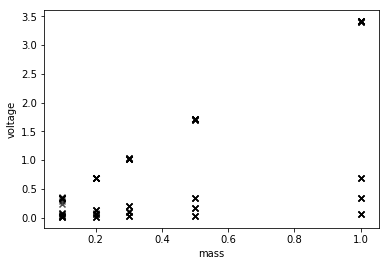

In [5]:

voltage = data.loc[:, 'dV'].values # V
sensitivity = data.loc[:, 'sensitivity'].values # pC
mass = data.loc[:, 'actual_mass'].values # kg

## plot
MPP.scatter(mass, voltage, marker = 'x', color = 'k', alpha = 0.7)
MPP.gca().set_xlabel('mass')
MPP.gca().set_ylabel('voltage')
MPP.show()


Well, it's linear, but four sensitivities add in there.

Now, some start values can improve the following regression by constraining the plausible range of priors.

In [6]:
## fint the sensitivity that was sampled the most
all_sensitivities, sensitivity_counts = NP.unique(sensitivity, return_counts=True)
most_sensitivity = all_sensitivities[NP.argmax(sensitivity_counts)]



## simple regression to get start values
slope_start, intercept_start, r_value, p_value, std_err \
        = STATS.linregress( \
                   mass[sensitivity == most_sensitivity] / most_sensitivity \
                   , voltage[sensitivity == most_sensitivity] \
                          )
print (slope_start, intercept_start, r_value, p_value, std_err)
std_err = 2.


341.6948771389306 -0.003837846430227332 0.9998662336521504 2.067573953822662e-87 0.8067702140404932


Remember $341.7$, it is what conventional regression would have given us.

Now take the voltage-force-relation from before and turn it into a Bayesian model.

In [7]:

#we'll do this in a "Model" environment, so we can access our model later.
with PM.Model() as linear_model:

    ## First, assemble all the model components.
    
    # the slope that we want to find
    slope = PM.Normal( 'slope' \
                     , mu = slope_start \
                     , sd = std_err \
                    )

    # intercept, should be zero (no loading, no force)
    # I include it to get another indication whether the calibration measurement is accurate.
    intercept = PM.Normal( 'intercept' \
                         , mu = intercept_start \
                         , sd = std_err \
                        )

    # measurement inaccuracy
    residual = PM.HalfCauchy('residual', 1. )

    # we use Student T likelihood distribution 
    # to check ex post wether our measurement uncertainty is normally distributed. 
    dof = PM.Gamma('dof', 5., 0.1)

    # empirical formula intruduced above
    estimator = intercept + slope * mass / sensitivity 
    
    # here comes the Bayesian likelihood variable: 
    # the posterior distribution that models tha observed data
    likelihood = PM.StudentT( 'likelihood' \
                            , mu = estimator \
                            , sd = residual \
                            , nu = dof \
                            , observed = voltage \
                            )


**Important:**

We here use the estimator

\begin{equation}slope * mass / sensitivity\end{equation}

which is a rearrangement of the force formula above. For calibration, we know the masses, and we observe voltages. Voltages are thus taken as the inputs to calculate the posterior probability density. 

For conversion of real data, we will of course turn this around again.

Do not worry at this point if you have no clue about Bayesian statistics. 

MCMC sampling will simply estimate the model parameters. You can go later to read [documentation](https://docs.pymc.io/?target=_blank), [good books](https://xcelab.net/rm/statistical-rethinking/?target=_blank) or watch [excellent courses](https://www.youtube.com/playlist?list=PLDcUM9US4XdNM4Edgs7weiyIguLSToZRI?target=_blank).

In [8]:
n_steps = 10000
with linear_model:

    trace = PM.sample(draws = n_steps \
                    , tune = n_steps \
                    , progressbar = True \
                    , nuts_kwargs={'target_accept': 0.99} \
                    , cores = 4 \
                    )




Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [dof, residual, intercept, slope]
Sampling 4 chains: 100%|██████████| 80000/80000 [01:16<00:00, 1047.79draws/s]


                mean    hpd_2.5   hpd_97.5
slope      341.27746  341.12490  341.42683
intercept    0.00054    0.00019    0.00090
residual     0.00125    0.00078    0.00176
dof          1.12377    0.71180    1.58896


/usr/lib/python3.7/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


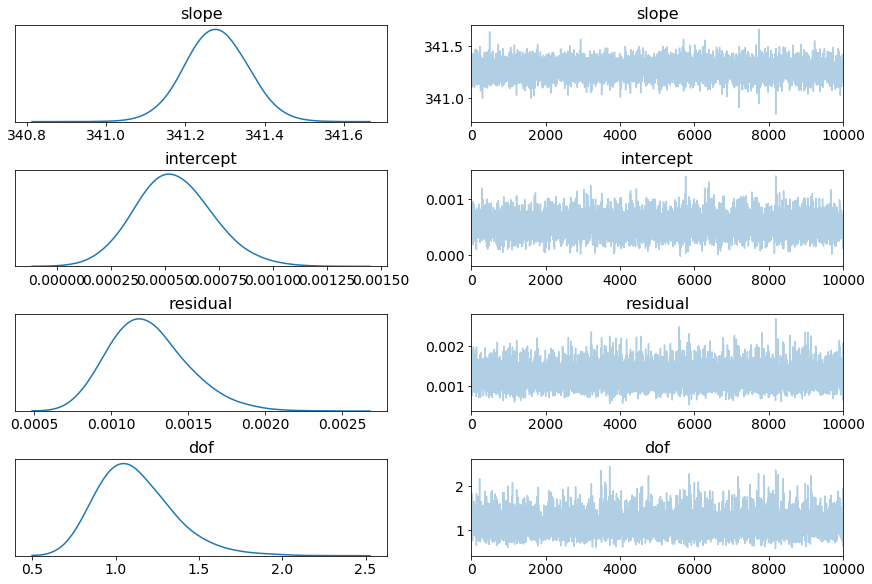

In [9]:
summary = PM.stats.summary(trace)
print (summary.loc[:, ['mean', 'hpd_2.5', 'hpd_97.5']])
#print (summary.loc[:, 'mean'].to_dict())

# show the posterior distribution of the model parameters
PM.traceplot(trace, combined = True) 
MPP.show()

In [10]:
summary

mean       sd     mc_error    hpd_2.5   hpd_97.5        n_eff  \
slope      341.27746  0.07710  4.63736e-04  341.12490  341.42683  25452.15504   
intercept    0.00054  0.00018  9.44197e-07    0.00019    0.00090  21048.79859   
residual     0.00125  0.00025  1.85358e-06    0.00078    0.00176  16254.90675   
dof          1.12377  0.23240  1.70318e-03    0.71180    1.58896  16817.04873   

              Rhat  
slope      1.00011  
intercept  1.00005  
residual   0.99998  
dof        1.00003

This particular forceplate has a slope of $341.28 \frac{V\cdot pC}{kg}$, which, together with the gain setting, can be used to convert voltage outputs to force.

Note that the intercept is sufficiently close to zero, Rhat (Gelman-Rubin statistics) is sufficiently close to one, and dof indicate that a wide-tailed distribution is a more accurate fit.

But that's all just to confirm that MCMC sampling converged. 

Let's rather view the outcome in a plot:

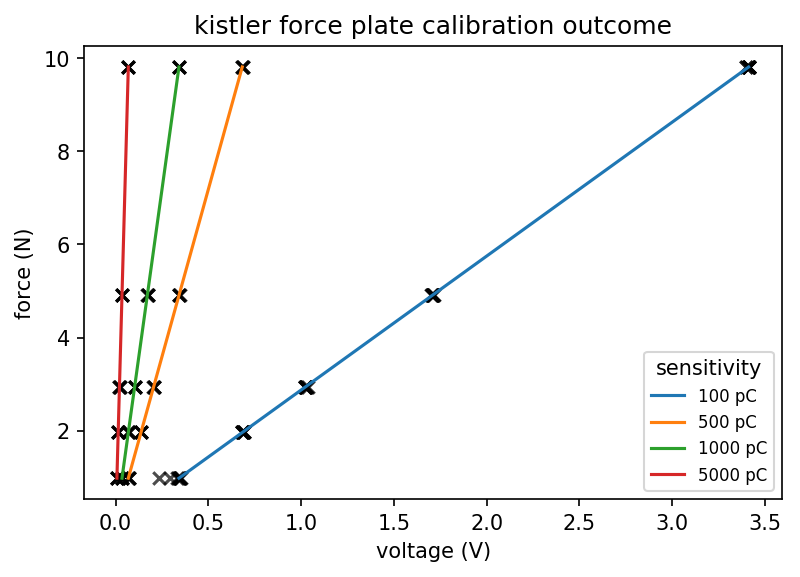

In [11]:
slope = summary.loc['slope', 'mean']
g = 9.81

## plot
fig = MPP.figure(dpi = 150)
ax = fig.add_subplot(1,1,1)

ax.scatter(voltage, mass * g, marker = 'x', color = 'k', alpha = 0.7)
ax.set_xlabel('voltage (V)')
ax.set_ylabel('force (N)')

mass_probes = NP.linspace(0.1,1.,101, endpoint = True)
for sens in all_sensitivities:
    ax.plot(mass_probes*slope/sens, mass_probes * g, ls = '-', label = '%i pC' % (sens))

ax.set_title('kistler force plate calibration outcome')
ax.legend(loc = 4, fontsize = 8, title = 'sensitivity')
MPP.show()


As you can see, this calibration can be used to convert a voltage into a force. 
Just plug the slope and sensitivity setting into the formula above, and convert your measured data.

## Why Probabilistic?

Probabilistic models return the probability distribution of the true underlying value of a measurement. 
It does so by MCMC modeling, which involves a step that uses the Bayesian theorem, but that's technical detail. 

If our model outputs the following:

In [12]:
print(summary.loc['slope', ['hpd_2.5', 'hpd_97.5']])

hpd_2.5     341.12490
hpd_97.5    341.42683
Name: slope, dtype: float64


Then, given the data we measured, it is $95\%$ certain that the true slope will lie between $341.12$ and $341.43$ (might vary a bit due to random sampling).

We can calculate what error that would mean at $1 kg$ of mass, $100 pC$:


In [13]:
force_min = 1.*summary.loc['slope', 'hpd_2.5']/100
force_max = 1.*summary.loc['slope', 'hpd_97.5']/100

uncertainty = force_max/force_min 
print (uncertainty)

1.000885097744795


This indicates that our force measurements at this order of magnitude will be accurate to $\pm 0.09 \%$. I find that rather impressive, given it took me something just more than 10 minutes to get the data.

If this is too inaccurate for a specific purpose, one can easily sample more masses and take more repeated measurements. The more data you sample, the more will the posterior distribution reflect that data and converge to the actual uncertainty of your measurement. 

## Summary

This notebook outlined how I suggest to generate measurements for calibration, and how to estimate the voltage-force conversion with probabilistic (robust) linear regression. 

Feel free to comment or add below!


## Next:
[ForcePlates IV: Calibration of Sensor Depth](../fpcalibration2)

This demonstration is useful if you want to measure the directionless magnitude of forces. 

However, in many applications, one requires also the contact point, or centre of pressure, at which the force applies to the force plate. 

That second calibration is covered in the next post.